In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('crypto_30min.csv', index_col='date')

# Top3. Momentum vs Reversion (periods from 30min to 24h)

In [11]:
index = ['30min', '1h', '2h', '4h', '6h', '8h', '10h', '12h', '16h', '20h', '24h']
periods = [1, 2, 4, 8, 12, 16, 20, 24, 32, 40, 48]
columns = ['top_cp_mean', 'top_np_mean', 'bot_cp_mean', 'bot_np_mean', 'market_mean', 'btc_mean']

In [12]:
results = pd.DataFrame(index=index, columns=columns)
topN = 3
saved_returns = {}

for i,p in zip(index,periods):
    all_ret = pd.DataFrame(columns=['top_cp', 'top_np', 'bot_cp', 'bot_np', 'market', 'btc'])
    
    # use all possible start times for a given period
    for s in range(p):
        tmpdf = df.iloc[s::p,:] # create df with given timedelta
        returns = tmpdf.pct_change().dropna()
        returns_shifted = returns.shift().dropna()
        returns = returns.iloc[1:]

        for tm in returns_shifted.index:
            # check that top returns are positive and bottom are negative
            sorted_idx_neg = returns_shifted.loc[tm][returns_shifted.loc[tm]<0].sort_values().index
            sorted_idx_pos = returns_shifted.loc[tm][returns_shifted.loc[tm]>0].sort_values().index
            top_idx = sorted_idx_pos[-topN:]
            bot_idx = sorted_idx_neg[:topN]
            if len(top_idx)>0:
                top_cp = returns_shifted.loc[tm,top_idx].sum()/len(top_idx)
                top_np = returns.loc[tm,top_idx].sum()/len(top_idx)
            else:
                top_cp = 0
                top_np = 0
            if len(bot_idx)>0:
                bot_cp = returns_shifted.loc[tm,bot_idx].sum()/len(bot_idx)
                bot_np = returns.loc[tm,bot_idx].sum()/len(bot_idx)
            else:
                bot_cp = 0
                bot_np = 0

            all_ret = all_ret.append({'top_cp':top_cp, 'top_np':top_np, 'bot_cp':bot_cp, 'bot_np':bot_np, 
                                      'market':returns_shifted.loc[tm].mean(), 
                                      'btc':returns_shifted.loc[tm]['BTC']}, ignore_index=True)
    # create new row
    row = {'top_cp_mean':all_ret['top_cp'].mean(), 'top_np_mean':all_ret['top_np'].mean(), 
           'bot_cp_mean':all_ret['bot_cp'].mean(), 'bot_np_mean':all_ret['bot_np'].mean(), 
           'market_mean':all_ret['market'].mean(), 'btc_mean':all_ret['btc'].mean()}
    results.loc[i] = row
    
    # save all_ret
    saved_returns[i] = all_ret

In [13]:
results

,top_cp_mean,top_np_mean,bot_cp_mean,bot_np_mean,market_mean,btc_mean
30min,0.011966,-0.000565,-0.009721,0.001127,0.000139,0.000086
1h,0.016994,-0.000486,-0.012917,0.001315,0.000276,0.000171
2h,0.024464,0.000055,-0.017249,0.00203,0.000542,0.000335
4h,0.035429,0.001399,-0.022946,0.002635,0.00108,0.00068
6h,0.044583,0.00305,-0.027187,0.003702,0.001608,0.001025
8h,0.052687,0.004344,-0.030403,0.00384,0.002176,0.001397
10h,0.060393,0.005981,-0.033225,0.003927,0.002789,0.001801
12h,0.067398,0.007787,-0.035594,0.004207,0.003401,0.002206
16h,0.07957,0.011362,-0.040073,0.004593,0.004577,0.002974
20h,0.091457,0.014164,-0.0437,0.005362,0.005784,0.003739


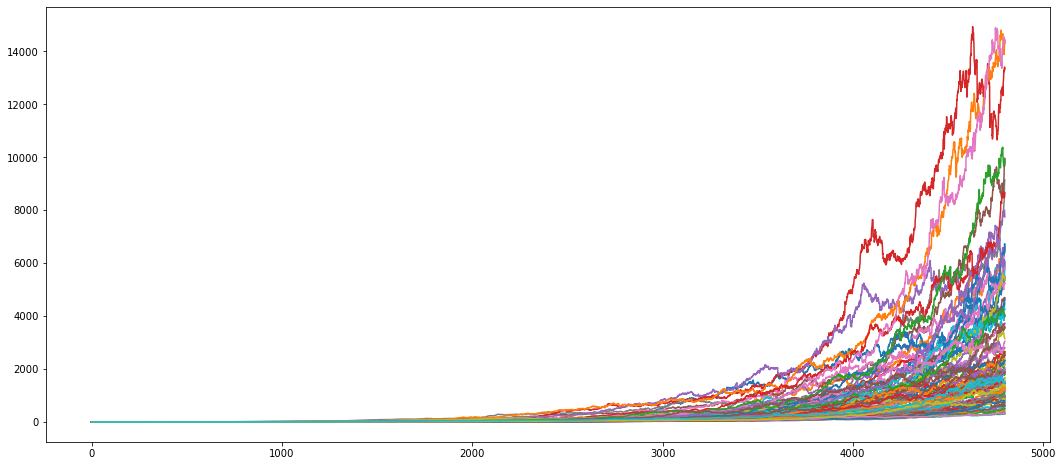

In [25]:
total_returns = []

plt.figure(figsize=(18,8))
for _ in range(100):
    ret_short = -np.random.choice(saved_returns['30min']['top_np'], size=4800)
    ret_long = np.random.choice(saved_returns['30min']['bot_np'], size=4800)
    ret = ret_long + ret_short
    cumret = (ret+1).cumprod()
    plt.plot(cumret)
    total_returns.append((cumret[-1]-cumret[0])/cumret[0])

In [26]:
np.mean(total_returns)

2989.1108647711085

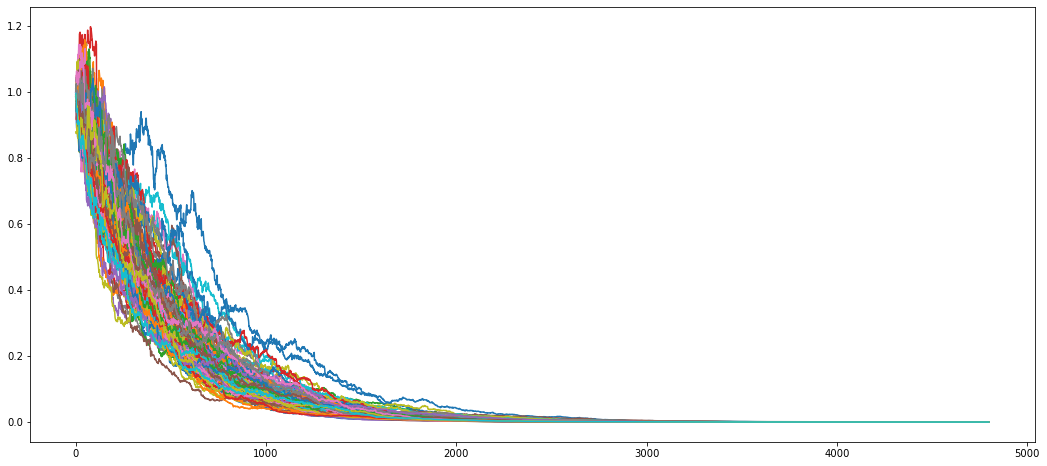

In [27]:
total_returns = []

plt.figure(figsize=(18,8))
for _ in range(100):
    ret_short = -np.random.choice(saved_returns['30min']['top_np'], size=4800)
    ret_long = np.random.choice(saved_returns['30min']['bot_np'], size=4800)
    ret = ret_long + ret_short
    cumret = (ret+1 - 4*0.001).cumprod()
    plt.plot(cumret)
    total_returns.append((cumret[-1]-cumret[0])/cumret[0])

In [28]:
np.mean(total_returns)

-0.9999863830304436

In [35]:
performance = pd.DataFrame(index=index[4:], columns = ['returns_mean', 'returns_std', 
                                                       'sharpe_mean', 'pct_losing'])

for i,p in zip(index[4:],periods[4:]):
    num_periods = np.floor(100*48/p).astype(int)
    
    total_returns = []
    sharpes = []
    
    for _ in range(100000):
        ret = np.random.choice(saved_returns[i]['top_np'], size=num_periods)
        cumret = (ret+1 - 0.001*2).cumprod() 
        tot_ret = (cumret[-1]-cumret[0])/cumret[0]
        total_returns.append(tot_ret)
        sharpe = np.sqrt(365*48/p)*np.mean(ret)/np.std(ret)
        sharpes.append(sharpe)
        
    
    total_returns = np.array(total_returns)
    pct_losing = np.sum(total_returns<0)/len(total_returns)
    performance.loc[i] = {'returns_mean':np.mean(total_returns), 'returns_std':np.std(total_returns), 
                          'sharpe_mean':np.mean(sharpes), 'pct_losing':pct_losing}

In [36]:
performance

,returns_mean,returns_std,sharpe_mean,pct_losing
6h,0.51536,1.211034,3.252239,0.40271
8h,1.008253,1.656132,3.437318,0.26213
10h,1.594885,2.270385,3.627284,0.17304
12h,2.149081,2.746898,3.900086,0.11432
16h,2.988691,3.599587,4.119149,0.07015
20h,3.22297,3.969069,4.044009,0.06299
24h,3.520891,4.556562,3.8912,0.05985


# Top1. Momentum vs Reversion (periods from 30min to 24h)

In [38]:
results = pd.DataFrame(index=index, columns=columns)
topN = 1
saved_returns = {}

for i,p in zip(index,periods):
    all_ret = pd.DataFrame(columns=['top_cp', 'top_np', 'bot_cp', 'bot_np', 'market', 'btc'])
    
    # use all possible start times for a given period
    for s in range(p):
        tmpdf = df.iloc[s::p,:] # create df with given timedelta
        returns = tmpdf.pct_change().dropna()
        returns_shifted = returns.shift().dropna()
        returns = returns.iloc[1:]

        for tm in returns_shifted.index:
            # check that top returns are positive and bottom are negative
            sorted_idx_neg = returns_shifted.loc[tm][returns_shifted.loc[tm]<0].sort_values().index
            sorted_idx_pos = returns_shifted.loc[tm][returns_shifted.loc[tm]>0].sort_values().index
            top_idx = sorted_idx_pos[-topN:]
            bot_idx = sorted_idx_neg[:topN]
            if len(top_idx)>0:
                top_cp = returns_shifted.loc[tm,top_idx].sum()/len(top_idx)
                top_np = returns.loc[tm,top_idx].sum()/len(top_idx)
            else:
                top_cp = 0
                top_np = 0
            if len(bot_idx)>0:
                bot_cp = returns_shifted.loc[tm,bot_idx].sum()/len(bot_idx)
                bot_np = returns.loc[tm,bot_idx].sum()/len(bot_idx)
            else:
                bot_cp = 0
                bot_np = 0

            all_ret = all_ret.append({'top_cp':top_cp, 'top_np':top_np, 'bot_cp':bot_cp, 'bot_np':bot_np, 
                                      'market':returns_shifted.loc[tm].mean(), 
                                      'btc':returns_shifted.loc[tm]['BTC']}, ignore_index=True)
    # create new row
    row = {'top_cp_mean':all_ret['top_cp'].mean(), 'top_np_mean':all_ret['top_np'].mean(), 
           'bot_cp_mean':all_ret['bot_cp'].mean(), 'bot_np_mean':all_ret['bot_np'].mean(), 
           'market_mean':all_ret['market'].mean(), 'btc_mean':all_ret['btc'].mean()}
    results.loc[i] = row
    
    # save all_ret
    saved_returns[i] = all_ret

In [39]:
results

,top_cp_mean,top_np_mean,bot_cp_mean,bot_np_mean,market_mean,btc_mean
30min,0.018089,-0.000503,-0.013626,0.001228,0.000139,0.000086
1h,0.025696,-0.000087,-0.017757,0.001423,0.000276,0.000171
2h,0.037082,0.000557,-0.023522,0.002499,0.000542,0.000335
4h,0.054112,0.002883,-0.030826,0.003409,0.00108,0.00068
6h,0.068205,0.004835,-0.036203,0.005146,0.001608,0.001025
8h,0.080564,0.005716,-0.040308,0.005399,0.002176,0.001397
10h,0.092138,0.008109,-0.043705,0.005898,0.002789,0.001801
12h,0.10291,0.012239,-0.046677,0.006099,0.003401,0.002206
16h,0.123202,0.018021,-0.05208,0.006237,0.004577,0.002974
20h,0.142723,0.021599,-0.05671,0.008001,0.005784,0.003739


In [41]:
performance = pd.DataFrame(index=index[4:], columns = ['returns_mean', 'returns_std', 
                                                       'sharpe_mean', 'pct_losing'])

for i,p in zip(index[4:],periods[4:]):
    num_periods = np.floor(100*48/p).astype(int)
    
    total_returns = []
    sharpes = []
    
    for _ in range(100000):
        ret = np.random.choice(saved_returns[i]['top_np'], size=num_periods)
        cumret = (ret+1 - 0.001*2).cumprod() 
        tot_ret = (cumret[-1]-cumret[0])/cumret[0]
        total_returns.append(tot_ret)
        sharpe = np.sqrt(365*48/p)*np.mean(ret)/np.std(ret)
        sharpes.append(sharpe)
        
    
    total_returns = np.array(total_returns)
    pct_losing = np.sum(total_returns<0)/len(total_returns)
    performance.loc[i] = {'returns_mean':np.mean(total_returns), 'returns_std':np.std(total_returns), 
                          'sharpe_mean':np.mean(sharpes), 'pct_losing':pct_losing}

In [42]:
performance

,returns_mean,returns_std,sharpe_mean,pct_losing
6h,2.130264,5.635034,2.963537,0.34953
8h,2.028816,4.84861,2.786709,0.32499
10h,3.272021,7.235557,3.081273,0.22901
12h,6.521815,13.808945,3.667729,0.12396
16h,9.61249,24.326298,3.738194,0.09515
20h,9.089491,26.554983,3.248002,0.12762
24h,14.338842,48.973169,3.409092,0.08823
